# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Audio
from numpy.fft import fft, ifft

%matplotlib inline

C:\Users\Levin\AppData\Local\Temp\ipykernel_1040\2855422734.py:5: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


# Read audio input

Using scipy.io.wavefile to read the wave file. Each of the two stereo channels is stored into a seperate list.

In [2]:
filename = '1'
samplerate, data = read(f'sampledata/singles/{filename}.wav')

# data_lt = data[:, 0] # left channel
# data_rt = data[:, 1] # right channel

C:\Users\Levin\AppData\Local\Temp\ipykernel_1040\2249313869.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = read(f'sampledata/singles/{filename}.wav')


# Remove signs from raw data

In [3]:
data = np.abs(data)

# Plot waveform

Using matplotlib.pyplot, the signal is plotted.

Using the line magic function ```%matplotlib inline```, the plot is output directly below the next Jupyter cell.

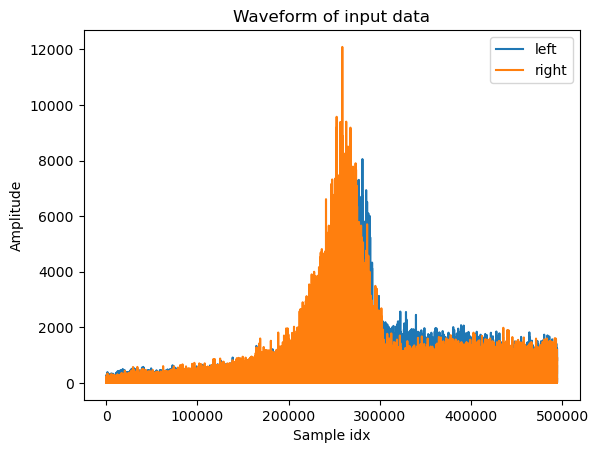

In [4]:
plt.figure()
plt.plot(data)
plt.xlabel("Sample idx")
plt.ylabel("Amplitude")
plt.title("Waveform of input data")
plt.legend(["left", "right"])
plt.show()

# Average input data

Calculates the average amplitude for every ```1 / res``` seconds.
(e.g. set ```res = 2``` to generate two average points per second)

*Note: During averaging, both channels are combined into one main average channel*

In [5]:
res: int = 12

step_increase: int = (int) (samplerate / res)

output_debug_list = []

avg_data = []
for samples in range(0, len(data), step_increase):
    tmp = np.average(data[samples : (samples + step_increase)])
    
    avg_data.append(np.average(data[samples: samples + step_increase]))

    # generate debug output
    inner_debug_list = []
    inner_debug_list.append(samples / samplerate)
    inner_debug_list.append((samples + step_increase) / samplerate)
    inner_debug_list.append(tmp)
    output_debug_list.append(inner_debug_list)


In [10]:
df = pd.DataFrame(output_debug_list, columns=['Von', 'Bis', 'Amp'])
df.style.background_gradient(axis=0, subset=['Amp'])

df.to_csv(f'sampledata/singles/csv/{filename}.csv', index=True, sep=';', encoding='utf8')

# keep remainder of cell empty to display table with gradient


# Calculate rate of change

Equivalent to calculating the slope of a curve.

Here, the slope is calculated using the np.gradient(list) function.

<Figure size 640x480 with 0 Axes>

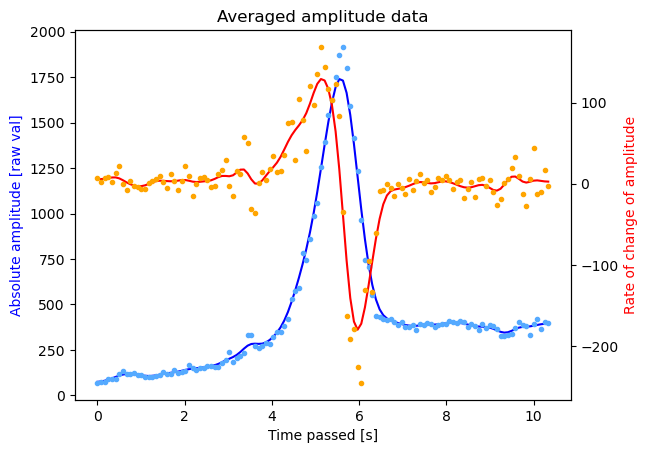

In [7]:
avg_smoothed = gaussian_filter1d(avg_data, sigma=2)

gradients = np.gradient(avg_data)
gradients_smoothed = gaussian_filter1d(gradients, sigma=2) #! Caution: may heavily alter the values

def plot_amplitude_data(data1, data1dots=None, data2=None, data2dots=None):
    x = np.linspace(0, len(data1) / res, len(data1))

    plt.figure()
    fig, ax = plt.subplots()
    ax.plot(x, data1, "-b", label="data1")
    if data1dots is not None:
        ax.plot(x, data1dots, ".", color="#55AAFF", label="data1 dots")
    ax.set_xlabel("Time passed [s]")
    ax.set_ylabel("Absolute amplitude [raw val]", color="blue")

    if data2 is not None:
        ax2 = ax.twinx()
        ax2.plot(x, data2, "-r", label="data2")
        if data2dots is not None:
            ax2.plot(x, data2dots, ".", color='#FFA500', label="data2 dots")
        ax2.set_xlabel("Time passed [s]")
        ax2.set_ylabel("Rate of change of amplitude", color="red")
    plt.title("Averaged amplitude data")
    plt.show()

plot_amplitude_data(avg_smoothed, avg_data, gradients_smoothed, gradients)

# Make symmetrical

Find the highest point of the curve, then average the points to the left with the points to the right.

(array([66], dtype=int64),)
66


<Figure size 640x480 with 0 Axes>

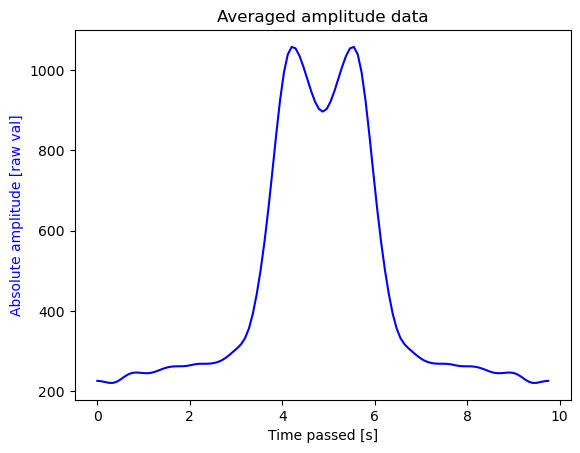

In [11]:
max_val = np.amax(avg_smoothed)
max_idx = np.where(avg_smoothed == max_val) # returns list
print(max_idx)
max_idx = int(np.average(max_idx)) # center of maxima
print(max_idx)

# find closer border
max_array_left_side = max_idx # number of elements to the left
max_array_right_side = len(avg_smoothed) - max_idx # number of elements to the right
symm_array_size = min(max_array_left_side, max_array_right_side) * 2 + 1 # new total number of elements

symmetrical_array = [0] * symm_array_size
for i_symm in range(symm_array_size):
    symmetrical_array[i_symm] = (avg_smoothed[i_symm] + avg_smoothed[symm_array_size - 1 - i_symm]) / 2

plot_amplitude_data(symmetrical_array)

dB Umrechnung: https://www.dsprelated.com/showthread/comp.dsp/29246-1.php

Inverse Square Law: https://web.archive.org/web/20210124224420/https://uc.yamaha.com/insights/blog/2020/march/inverse-square-law-what-is-it/

Relation Intensity ~ Amplitude: https://physics.stackexchange.com/questions/322498/what-is-the-relationship-between-amplitude-and-the-distance-from-the-source-of-a

https://www.quora.com/How-does-amplitude-change-with-distance-1



Rekursive Annäherung:

Funktion x-Verschiebung berechnen, dann r/x -> r brute force mäßig ermitteln

Gütefunktion: Abstand der Messpunkte zur Funktion entlang der y-Achse; Betrag oder Quadrierung, da Funktion über oder unter Punkt liegen kann

\\-> Ausprobieren, ob Betrag oder Quadrat besser; wahrscheinlich Quadrat besser, da größere Abweichungen stärker gewichtet werden